# Анализ результатов А/В-теста

В нашем распоряжении данные о гипотезах, заказах и группах A/B тестирования во все дни проведения теста

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.
Нужно приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Цели исследования:**

- приоритизировать гипотезы

- провести анализ A/B тестирования

**Ход исследования:**

1. Обзор данных
2. Предобработка данных
3. Приоритизация гипотез
4. Анализ A/B теста
5. Общий вывод

In [1]:
# Импортируем нужные нам библиотеки

import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

## Обзор данных

In [2]:
# Записываем данные из файлов в переменные

hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Всего в таблице 9 строк (в нашем случае гипотез), пропущенных значений нет, нужно привести названия столбцов к нижнему регистру.

In [4]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В таблице 1197 строк, пропусков нет, для удобства на этапе предобработки изменим названия столбцов, также нужно изменить тип данных в столбце с датой.

In [5]:
visitors.info()
visitors.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718


В таблице 62 строки, пропусков нет. Нужно изменить тип данных в столбце с датой.

### Промежуточный вывод по этапу обзора данных

В полученных таблицах отсутствуют пропущенные значения. В некоторых таблицах стоит изменить названия столбцов, а также привести столбцы с датой к типу datetime.

## Предобработка данных

Для начала приведем названия столбцов к змеиному регистру

In [6]:
# С помощью цикла проходимся по трем таблицам

for x in [hypothesis, orders, visitors]:
    x.columns = x.columns.str.lower()
orders.columns = orders.columns.str.replace('id', '_id')

Теперь изменим типы данных

In [7]:
for x in [orders, visitors]:
    x['date'] = pd.to_datetime(x['date'])

Поверим данные на наличие пропусков

In [8]:
for x in [hypothesis, orders, visitors]:
    print(x.isna().sum(), '\n')

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64 

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64 

date        0
group       0
visitors    0
dtype: int64 



Теперь проверим данные на наличие явных дубликатов

In [9]:
for x in [hypothesis, orders, visitors]:
    print(x.duplicated().sum(), '\n')

0 

0 

0 



Возможно некоторые пользователи попали и в группу А и в группу В, стоит это проверить

In [10]:
# С помощью метода isin() проверяем группы на наличие одних и тех же пользователей

orders.query('group == "A"')['visitor_id'].drop_duplicates()\
.isin(orders.query('group == "B"')['visitor_id'].drop_duplicates()).sum()

58

Так и есть, 58 пользователей попали в обе группы, наблюдения таких пользователей теперь не являются независимыми, так как им сначала показывается один вариант, потом другой. Поэтому они могут по-разному реагировать. По-хорошему их нужно удалить , но данные в таблице с визитами являются агрегированными, так что эти пользователи в любом случае будут учавствовать в анализе. Если бы таблица по визитам была неагрегированная, то такие пользователи были бы удалены.

Посмотрим на таблицы после всех изменений

In [11]:
hypothesis.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame

### Промежуточный вывод по этапу предобработки данных

**Пропуски:** пропуски отсутствуют во всех таблицах

**Дупликаты:** дупликатов также нет

**Аномальные значения:** для наглядной оценки влияния аномальных значений на исследование сначала проанализируем результаты A/B тестирования с аномальными значениями, потом без них.

**Типы данных:** был изменени тип даннных в столбцах с датой на datetime 

Также было найдено 58 пользователей, которые попали в обе группы, было принято решение не удалять данные этих пользователей. Ведь так или иначе они будут принимать участие в анализе из-за наличия таких пользователей в таблице с визитами, в которой данные являются агрегированными, и поэтому их нельзя оттуда удалить.

## Приоритизация гипотез

Теперь расставим гипотезы в порядке приоритета с помощью двух фрейворков: ICE и RICE

In [12]:
# Считаем ICE и выводим отсортированный результат

pd.set_option('display.max_colwidth', 0)

hypothesis['ICE'] = round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'], 1)

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Здесь гипотеза под номером 8 имеет наивысший приоритет (из-за высоких показателей impact и confidence), номер 4 - низший./

In [13]:
# Считаем RICE и выводим отсортированный результат

hypothesis['RICE'] = hypothesis['reach']*hypothesis['ICE']

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",39.9
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8.8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3.9
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Теперь гипотеза под номером 7 имеет высший приоритет, также заметим, что гипотезы 7 и 0 в обоих случаях находятся в топ-3.

### Промежуточный вывод по этапу приоритизации гипотез

При расчете ICE и RICE наблюдаются немного разные картины. Такое изменение связано с тем, что между RICE и ICE есть прямо-пропорциональная зависимость с коэффициентом R (Reach), который показывает охват пользователей. Грубо говоря, результаты, полученные при расчете ICE, просто домнажаются на Reach. Но это не говорит о том, что гипотеза под номером 7 охватывает наибольшее количество пользователей, ведь при расчете учитываются и другие показатели.

## Анализ A/B теста

Для начала создадим таблицу, из которй потом будем брать данные для построения графиков

In [14]:
# Для создания уникальных пар "дата-группа" убираем дупликаты

datesGroups = orders[['date','group']].drop_duplicates()

# Применяем лямбда функцию для подсчета кумулятивных метрик, используя при этом метод np.logical_and,
# чтобы применять нашу функцию только к определенным данным

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group']==x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# С помощтю метода .merge() соединяем полученные таблицы и получаем кумулятивные данные

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Построение графиков

Теперь построим график кумулятивной выручки по группам

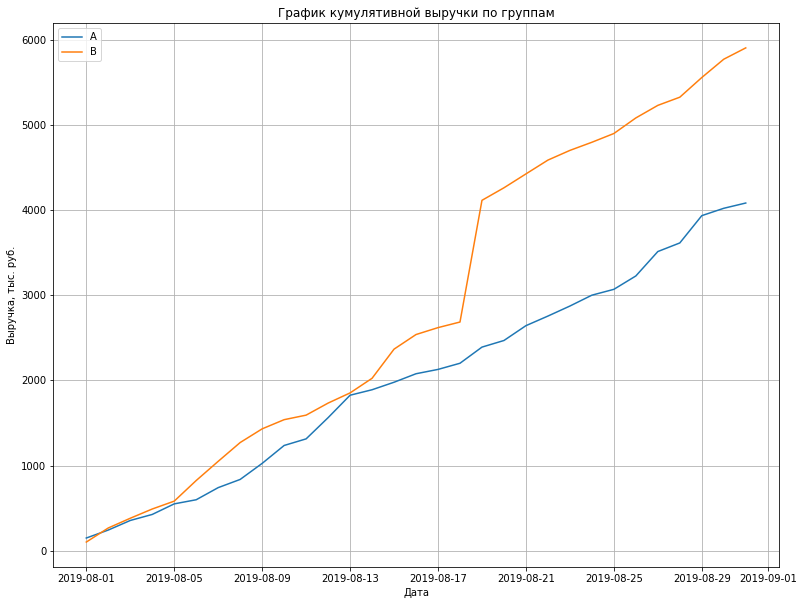

In [15]:
# Делаем срезы по группам А и В

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Задаем параметры для построения графика

plt.figure(figsize=(13,10))
plt.grid(True)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/1000, label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/1000, label='B')

plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка, тыс. руб.');

С самого начала тестирования в группе В стабильно больше выручка, а 19 августа виден резкий скачок в этой группе, скорее всего это дорогой заказ, в дальнейшем мы удалим такие аномальные значения, но для начала поработаем с "сырыми" данными.

Построим график кумулятивного среднего чека

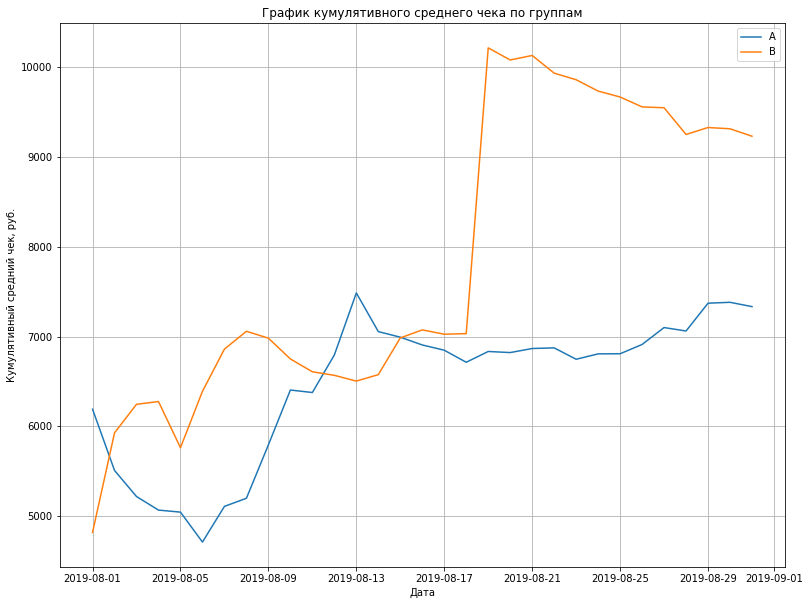

In [16]:
plt.figure(figsize=(13,10))
plt.grid(True)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек, руб.')
plt.legend();

Опять же виден резкий скачок 19 августа у группы В. В начале тестирования группа В лидировала, затем 8 августа группа А вышла вперед и при этом стабилизировалась, но из-за дорогого заказа группа В скакнула вверх, тоже стабилизировавшись, но если не учитывать эту покупку, то скорее всего группа А в конце теста была бы выше.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

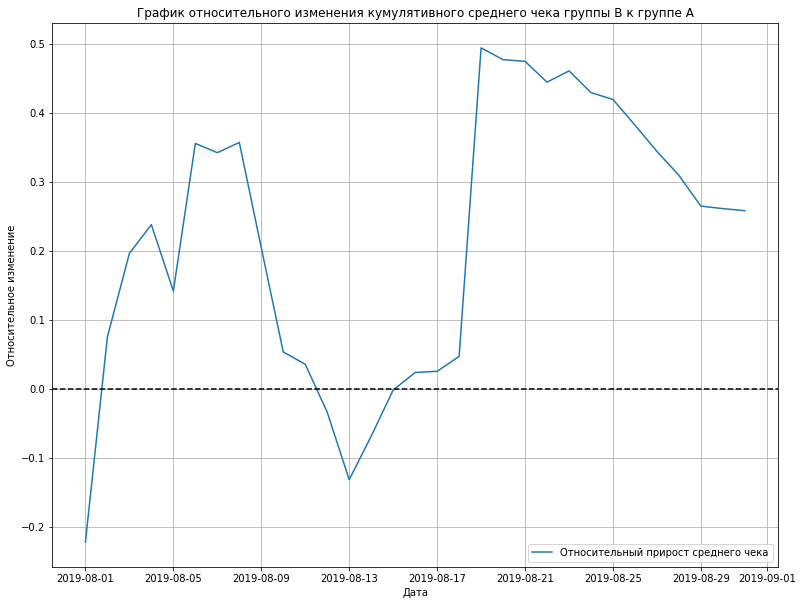

In [17]:
plt.figure(figsize=(13,10))
plt.grid(True)

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, label='Относительный прирост среднего чека')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.legend(loc='lower right');

Очень много резких скачков, кумулятивный средний чек группы В практически всегда выше группы А, кроме периода с 12 по 15 августа.

Построим график кумулятивного среднего количества заказов на посетителя по группам

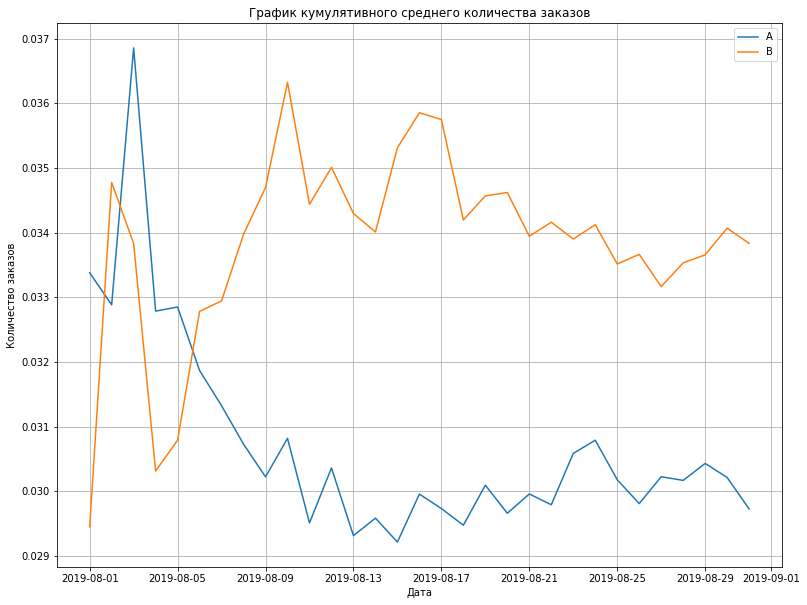

In [18]:
plt.figure(figsize=(13,10))
plt.grid(True)

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

Начиная с 6 августа кумулятивное среднее количество заказов группы В стабильно выше группы А, после 9 августа показатели стабилизировались.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

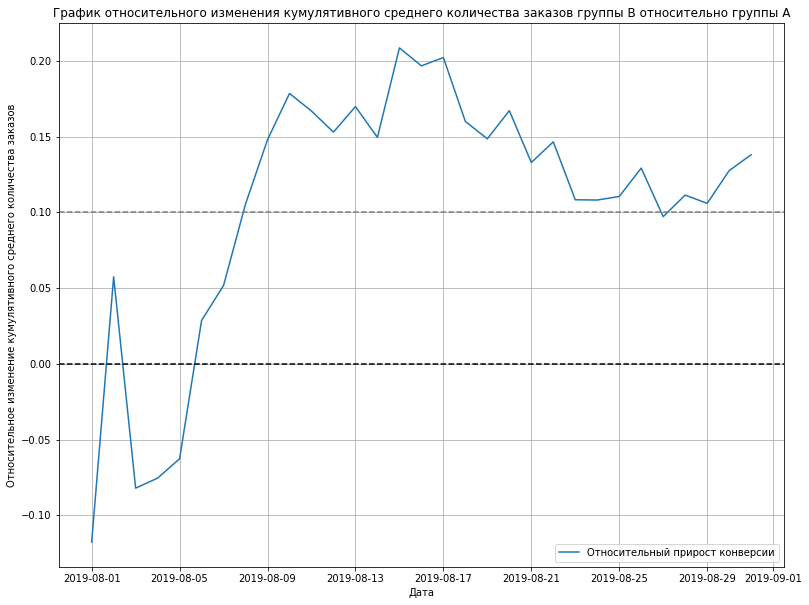

In [19]:
plt.figure(figsize=(13,10))
plt.grid(True)

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label = 'Относительный прирост конверсии')
plt.legend(loc='lower right')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов группы В относительно группы А')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивного среднего количества заказов'); 

Начиная с 6 августа количество заказов группы В стабильно выше, а начиная с 9 августа количество заказов группы В стабильно превышает группу А минимум в 1.1 раза.

### Определение аномальных значений 

Теперь построим точечный график количества заказов по пользователям

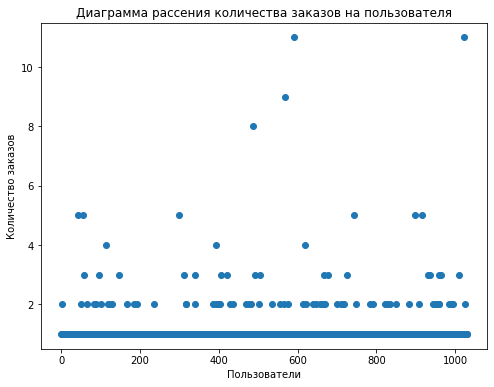

In [20]:
plt.figure(figsize=(8, 6))

# Группируем данные по столбцу visitor_id и считаем количество заказов и его группу

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique', 'group': 'max'})
)

ordersByUsers.columns = ['user_id', 'orders', 'group']

# Искусственно создаем нумерацию пользователей, чтобы график был более наглядный и без лишних чисел
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x = x_values, y = ordersByUsers['orders'])
plt.title('Диаграмма рассения количества заказов на пользователя')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов');

Большинство пользователей совершают только одну покупку, так же есть достаточно большое количество пользователей с 2-3 покупками.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.

In [21]:
# Считаем перцентили

np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Пользователи с 4-мя заказами и выше будут считаться выбросами

Посмотрим теперь на стоимость заказов

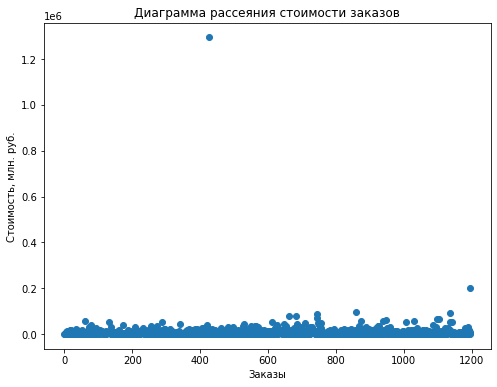

In [22]:
plt.figure(figsize=(8, 6))

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Диаграмма рассеяния стоимости заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость, млн. руб.');

Из-за слишком дорогого заказа не видно общей картины, изменим масштаб по оси у.

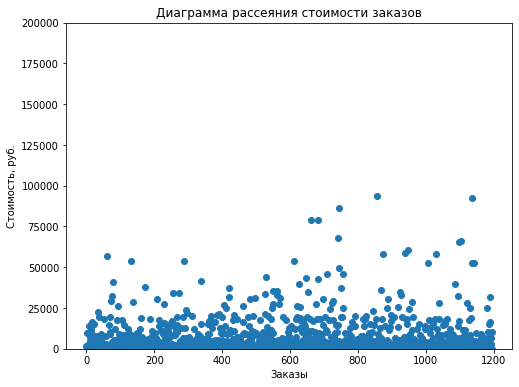

In [23]:
plt.figure(figsize=(8, 6))
plt.ylim(0, 200000)

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Диаграмма рассеяния стоимости заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость, руб.');

Можно сказать, что большинство заказов стоят не выше 50000 рублей, что примерно совпадает с 99-ым перцентилем - 58233 рубля.

Посчитаем 95-й и 99-й перцентили стоимости заказов и выберем границу для определения аномальных значений.

In [24]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Определим за верхнюю границу стоимости заказа 99-ый перцентиль - 58233 рубля.

### Проверка на статистическую значимость различий с помощью теста Манна-Уитни

Теперь посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Для более удобного расчета составим новую таблицу.

In [25]:
# Делаем срез по группам чтобы посчитать кол-во пользователей в день исследования

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitors_per_date_A']

# С помощью лямбда-функции считаем кумулятивное количество посетителей

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitors_cummulative_A']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitors_per_date_B']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitors_cummulative_B']

# Делаем то же самое, но теперь для стоимости и количества заказов

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B',
]

# Объединяем полученные выше таблицы с помощью метода .merge()

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Теперь у нас есть подробная информация по каждой группе.

Применим тест Манна-Уитни для подсчета статистической значимости различия среднего количества заказов по результатам месячного теста. Тест будем проводить на "сырых" данных. Уровень статистической значимости установим на 5%.

- **Нулевая гипотеза:** различий в среднем количестве заказов нет

- **Альтернативная гипотеза:** различия в среднем количестве заказов есть

In [26]:
# Группируем данные по группам А и В считая количество заказов

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

# Создаем два датафрейма для проведения теста Манна-Уитни

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

alpha = 0.05
p_value = st.mannwhitneyu(sampleA, sampleB)[1]
print("p-значение: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
print("Относительный прирост В к А: {0:.3%}".format(sampleB.mean() / sampleA.mean()-1))

p-значение: 0.017
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 13.808%


P-value меньше уровня статистической значимости, значит нулевую гипотезу можно отвергнуть, между группами есть различия в среднем количестве заказов. Относительный прирост группы В к А: 13.808%

Теперь применим тест Манна-Уитни для подсчета статистической значимости различия среднего чека заказа по результатам месячного теста. Тест будем проводить на "сырых" данных. Уровень статистической значимости установим на 5%.

- **Нулевая гипотеза:** различий в среднем чеке нет

- **Альтернативная гипотеза:** различия в среднем чеке есть

In [27]:
alpha = 0.05
p_value = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print("p-значение: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
print('Относительный прирост В к А: {0:.3%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение: 0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.871%


P-value сильно больше 5%, поэтому нет оснований считать группы разными даже при наличии аномальных значений. Относительный прирост В к А: 25.871%.

Теперь очистим данные от аномальных значений

In [28]:
# С помощью метода pd.concat объединяем списки аномальных пользователей по кол-ву заказов и их стоимости из двух групп

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 4]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] >= 4]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] >= 58233]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
23      237748145
949     887908475
744     888512513
Name: visitor_id, dtype: int64
20


Всего 20 аномальных пользователей, посмотрим как они повлияли на анализ. Уровень статистической значимости установим на 5%.

- **Нулевая гипотеза:** различий в среднем количестве заказов нет

- **Альтернативная гипотеза:** различия в среднем количестве заказов есть

In [29]:
# Фильтруем два датайрема, с помощью метода isin() ищем пользоватлей,
# которые есть среди аномальных и не учитываем их при построении датафрейма

sampleA_filtered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB_filtered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

alpha = 0.05
p_value = st.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]
print("p-значение: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
print("Относительный прирост В к А: {0:.3%}".format(sampleB_filtered.mean() / sampleA_filtered.mean()-1))

p-значение: 0.014
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 15.103%


Р-value все также больше 5%, но все-таки меньше на 0.3% чем в "сырых" данных, зато относительный прирост в среднем количестве заказов группы В к группе А повысился на 1.3% по сравнению с "сырыми" данными.

Теперь взглянем на средний чек. Уровень статистической значимости установим на 5%.

- **Нулевая гипотеза:** различий в среднем чеке нет

- **Альтернативная гипотеза:** различия в среднем чеке есть

In [30]:
# Фильтруем два датайрема, с помощью метода isin() ищем пользоватлей,
# которые есть среди аномальных и не учитываем их при построении датафрейма

alpha = 0.05
p_value = st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
print("p-значение: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
print("Относительный прирост В к А: {0:.3%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    ))

p-значение: 0.959
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -1.385%


P-value сильно вырос, все также нет оснований считать группы разными, а вот относительный прирост среднего чека группы В к группе А теперь отрицательный (-1.4%).

### Промежуточный вывод по этапу анализа А/В теста

Был проведен анализ А/В теста, который длился ровно месяц с 1 августа 2019 года по 31 августа 2019 года. 

- Построены графики кумулятивной выручки, кумулятивного среднего чека и кумулятивного среднего количества заказов в разделении по группам. Также были построены графики относительного изменения кумулятивного среденго чека и кумулятивного среднего количества заказов группы В к группе А.

- Для определение нижней границы аномальных значений были посчитаны 95-ые и 99-ые перцентили. Для количество заказов на покупателя граница была в 4 заказа, для стоимости заказа - в 58233 руб.

- При помощи теста Манна-Уитни были проведены тесты статистической значимости различий по разным метрикам в разделении по группам. Наличие или отсутствие аномальных значений не изменило результат исследования.

## Общий вывод

В нашем распоряжении данные о гипотезах, заказах и группах A/B тестирования во все дни проведения теста

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки. Нужно было приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

Все цели исследования были достигнуты:

- гипотезы приоритизированы

- А/В тест проанализирован

На этапе предобработки данных особых проблем не возникло: 

**Пропуски:** пропуски отсутствуют во всех таблицах

**Дупликаты:** дупликатов также нет

**Аномальные значения:** для наглядной оценки влияния аномальных значений на исследование удаление таких данных произошло на этапе проверки стаистической значимости различия между группами А и В.

**Типы данных:** был изменени тип даннных в столбцах с датой на datetime 

Также было найдено 58 пользователей, которые попали в обе группы, было принято решение не удалять данные этих пользователей. Ведь так или иначе они принимали участие в анализе из-за наличия таких пользователей в таблице с визитами, в которой данные являются агрегированными, и поэтому их нельзя оттуда удалить. Если бы таблица по визитам была неагрегированная, то такие пользователи были бы удалены.

При приоритизации гипотез наилучшим образом показали себя гипотезы под номерами 7 и 0, так как при расчете ICE и RICE они обе входили в топ-3.

Был проведен анализ А/В теста, который длился ровно месяц с 1 августа 2019 года по 31 августа 2019 года. 

- Построены графики кумулятивной выручки, кумулятивного среднего чека и кумулятивного среднего количества заказов в разделении по группам. Также были построены графики относительного изменения кумулятивного среднего чека и кумулятивного среднего количества заказов группы В к группе А.

- Для определение нижней границы аномальных значений были посчитаны 95-ые и 99-ые перцентили. Для количество заказов на покупателя граница была в 4 заказа, для стоимости заказа - в 58233 руб.

- При помощи теста Манна-Уитни были проведены тесты статистической значимости различий по разным метрикам в разделении по группам. Наличие или отсутствие аномальных значений не изменило результат исследования.

По результатам исследования было принято решение остановить проведение А/В теста и признать группу В победителем, так как относительный прирост кумулятивного среднего количества заказов группы В к группе А стабильно выше 10%, причем даже без учета аномальных значений группа В вырывается вперед при расчете кумулятивной выручки.